# 0810 PSA 미팅자료

## 모델 구분

1. Autoregressive model
    - LSTM Based Multivariate model

2. Generative model >> 변경?? (Generative vs Discriminative)
    - CNN 구조 테스트
    - Multivariate model 테스트

## 1. Autoregressive model 테스트

In [3]:
import time
from utils import *
from sequential_utils import *
import tensorflow as tf

from tensorflow.keras import layers, Sequential
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import RepeatVector,Lambda,LSTM, GRU, SimpleRNN, TimeDistributed, Dense, Activation, BatchNormalization, InputLayer,Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences


DataMerge :  
- 데이터 X : N X 9  
- 데이터 Y : N X 2500 X 5  
            
BatchGenerator :  
- 데이터 X1 (action): N X (seqlen) X 9  
- 데이터 X2 (state): N X (seqlen) X 5
- 데이터 Y  (state): N X (seqlen) X 5        
- Y는 X2가 1 time_step씩 딜레이된 데이터    

- N = 1024 * 3647

In [7]:
BATCH = 1024
WINDOW = 100
SAMPLING = 5
STRIDE = 3
LR = 1e-4
EPOCH = 10
NUM_CELL = 512
DR_RATES = 0.3
NUM_CH = 5

In [4]:
SEED=0
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Target variable to train & generate
variable = ['primary_pressure', 'primary_temperature', 'secondary_pressure', 'secondary_temperature', 'PCT']

# Create dataframe to store the mean and std of Absolute Percentage Error
Test_Results = pd.DataFrame(columns=['config','PP_avg','PP_std','PT_avg','PT_std','SP_avg','SP_std','ST_avg','ST_std','PCT_avg','PCT_std'])
Val_Results = pd.DataFrame(columns=['config','PP_avg','PP_std','PT_avg','PT_std','SP_avg','SP_std','ST_avg','ST_std','PCT_avg','PCT_std'])

DATA = DataMerge('./DATA')
DATA_test = DataMerge('./DATA/TestSet',SCALERS=DATA.SCALERS)


In [54]:
from sklearn.model_selection import train_test_split
SEED=0
X_train, X_test, Y_train, Y_test = train_test_split(DATA.X, DATA.Y, test_size=0.3, random_state=SEED)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.9, random_state=SEED)

Train_BG = BatchGenerator(X_train,Y_train, batch_size = BATCH, window_size = WINDOW, sampling_rate = SAMPLING, stride = STRIDE, shuffle = True )
Val_BG = BatchGenerator(X_val, Y_val,batch_size = BATCH, window_size = WINDOW, sampling_rate = SAMPLING, stride = STRIDE, shuffle = True )


In [55]:
## Create Model
#Get input
action = Input(shape=(None,9,))
state = Input(shape=(None,5,))

#Concat action and states
act_state = tf.concat([action, state],2)
#models
layer_1 = LSTM(NUM_CELL, return_sequences=True,dropout=DR_RATES)(act_state)
layer_2 = LSTM(NUM_CELL, return_sequences=True,dropout=DR_RATES)(layer_1)
# layer_3 = LSTM(num_cell, return_sequences=True,dropout=dr_rates)(layer_2)
output = TimeDistributed(Dense(NUM_CH, activation='elu'))(layer_2)

model= Model([action, state], output)

### With known SBLOCA  

- 처음 100개 데이터로부터 1개씩 예측.
- Sampling rate = 5이므로 실질적으로 500초까지의 데이터임.

In [56]:
model.load_weights('./Models/sequential_lstm/m1-0002.ckpt')
Test_X = X_test
Test_Y_samp = Y_test[:,range(0,2500,SAMPLING),...]

# iteratively generates predictions
TEMP_OUTPUT = np.empty((np.shape(Test_X)[0], int(2500/SAMPLING),5))
TEMP_OUTPUT[:,:100,:] = Test_Y_samp[:,:100,:]
for i in range(100,500):    
    test_action = np.tile(Test_X[:,np.newaxis,:],(1,100,1))
    test_state = TEMP_OUTPUT[:,(i-100):i,:]
    output = model.predict([test_action, test_state])    
    TEMP_OUTPUT[:,i,:] = output[:,99,:]

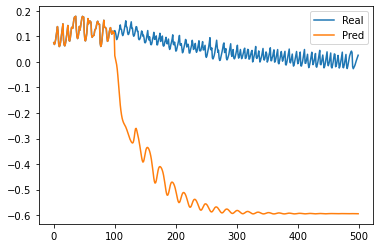

In [57]:
import matplotlib.pyplot as plt
i=2000
dim=0
plt.plot(Test_Y_samp[i,:,dim],label='Real')
plt.plot(TEMP_OUTPUT[i,:,dim],label='Pred')
plt.legend()
plt.show()

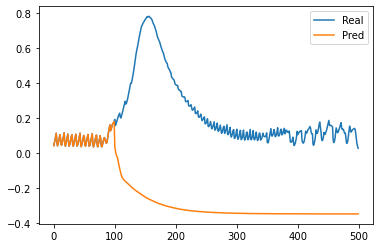

In [58]:
import matplotlib.pyplot as plt
i=0
dim=0
plt.plot(Test_Y_samp[i,:,dim],label='Real')
plt.plot(TEMP_OUTPUT[i,:,dim],label='Pred')
plt.legend()
plt.show()

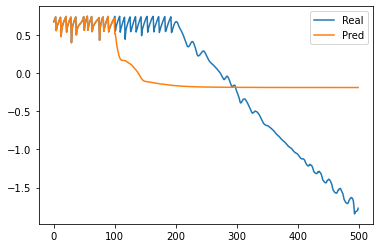

In [15]:

i=100
dim=3
plt.plot(Test_Y_samp[i,:,dim],label='Real')
plt.plot(TEMP_OUTPUT[i,:,dim],label='Pred')
plt.legend()
plt.show()

### With Unknown LOCA

In [59]:
Test_X = DATA_test.X
Test_Y_samp = DATA_test.Y[:,range(0,2500,SAMPLING),...]


TEMP_OUTPUT = np.empty((np.shape(Test_X)[0], int(2500/SAMPLING),5))
TEMP_OUTPUT[:,:100,:] = Test_Y_samp[:,:100,:]
for i in range(100,500):    
    test_action = np.tile(Test_X[:,np.newaxis,:],(1,100,1))
    test_state = TEMP_OUTPUT[:,(i-100):i,:]
    output = model.predict([test_action, test_state])    
    TEMP_OUTPUT[:,i,:] = output[:,99,:]

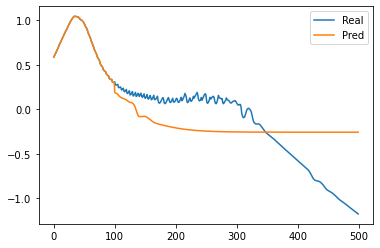

In [60]:
i=0
dim=0
plt.plot(Test_Y_samp[i,:,dim],label='Real')
plt.plot(TEMP_OUTPUT[i,:,dim],label='Pred')
plt.legend()
plt.show()

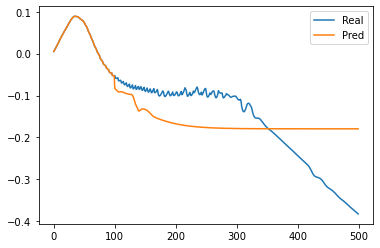

In [61]:
i=0
dim=4
plt.plot(Test_Y_samp[i,:,dim],label='Real')
plt.plot(TEMP_OUTPUT[i,:,dim],label='Pred')
plt.legend()
plt.show()

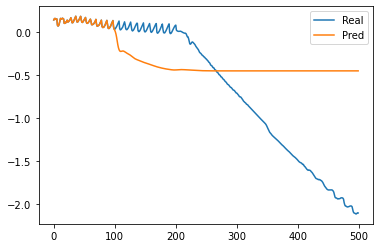

In [64]:
i=400
dim=0
plt.plot(Test_Y_samp[i,:,dim],label='Real')
plt.plot(TEMP_OUTPUT[i,:,dim],label='Pred')
plt.legend()
plt.show()

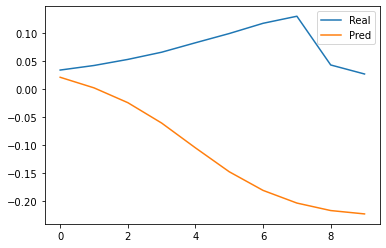

In [65]:
i=400
dim=0
plt.plot(Test_Y_samp[i,100:110,dim],label='Real')
plt.plot(TEMP_OUTPUT[i,100:110,dim],label='Pred')
plt.legend()
plt.show()

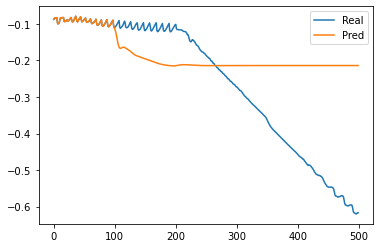

In [66]:
i=400
dim=4
plt.plot(Test_Y_samp[i,:,dim],label='Real')
plt.plot(TEMP_OUTPUT[i,:,dim],label='Pred')
plt.legend()
plt.show()

### 추가 학습 수행

## Multivariate model

- 데이터 X (action): N X (seqlen) X 9
- 데이터 Y (state): N X (seqlen) X 5

In [42]:
DATA = DataMerge('./DATA')
DATA_test = DataMerge('./DATA/TestSet',SCALERS=DATA.SCALERS)
SEED = 0
X_train, X_test, Y_train, Y_test = train_test_split(DATA.X, DATA.Y, test_size=0.3, random_state=SEED)
X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test, test_size = 0.9, random_state=SEED)

X_train_samp,Y_train_samp = augment_Y_by_resample(X_train,Y_train,5,return_all=True)
X_val_samp, Y_val_samp = augment_Y_by_resample(X_val,Y_val,5, return_all=True)

Y_train_samp_pad = pad_sequence_by_first(Y_train_samp,20)
Y_val_samp_pad = pad_sequence_by_first(Y_val_samp,20)

Test_Results = pd.DataFrame(columns=['config','PP_avg','PP_std','PT_avg','PT_std','SP_avg','SP_std','ST_avg','ST_std','PCT_avg','PCT_std'])
Val_Results = pd.DataFrame(columns=['config','PP_avg','PP_std','PT_avg','PT_std','SP_avg','SP_std','ST_avg','ST_std','PCT_avg','PCT_std'])
Test_Results2 = pd.DataFrame(columns=['config','PP_avg','PP_std','PT_avg','PT_std','SP_avg','SP_std','ST_avg','ST_std','PCT_avg','PCT_std'])


In [43]:
file_root = './DATA/Models/MV_gen5.hdf5'
def MV_TS_model_wPE_idle2(bidirect = True, RNN = 'LSTM', layer_norm = False, dr_rates = 0.3, num_pads=20):
    inputs = layers.Input(shape =(9) ,name='input')
    num_rows = tf.shape(inputs,name='num_rows')[0]
    pos_enc_tile = tf.tile(positional_encoding(500+num_pads,9), [num_rows, 1,1],name='pos_enc_tile')
    inputs_extend = RepeatVector(500+num_pads,name='extend_inputs')(inputs)
    inputs_extend_wPE = inputs_extend+pos_enc_tile
    # inputs_extend_wPE = tf.concat([inputs_extend, pos_enc_tile],2,name='input_pos_enc')

    layer_1 = Bidirectional(LSTM(128, return_sequences=True,dropout=dr_rates))(inputs_extend_wPE)
    layer_2 = Bidirectional(LSTM(128, return_sequences=True,dropout=dr_rates))(layer_1)
    # layer_1 = LSTM(128, return_sequences=True,dropout=dr_rates)(inputs_extend_wPE)
    # layer_2 = LSTM(128, return_sequences=True,dropout=dr_rates)(layer_1)
    layer_3 = TimeDistributed(Dense(64,activation='elu'))(layer_2)    
    outputs = TimeDistributed(Dense(5))(layer_3)
    model= Model(inputs, outputs)
    return model
K.clear_session()

model = MV_TS_model_wPE_idle2()
model.load_weights(file_root)

In [44]:

Y_hat = model.predict(DATA_test.X)[:,20:,:]
Y_hat_up = upscaling(Y_hat, sampling_rate=5)
Y_hat_up_ = Y_hat_up.copy()
Y_test_ = DATA_test.Y.copy()
for i,v in enumerate(variable):
    print(v)
    Y_hat_up_[...,i] = DATA.SCALERS[v].inverse_transform(Y_hat_up[...,i].reshape(-1,1)).reshape(-1,2500)
    Y_test_[...,i] = DATA.SCALERS[v].inverse_transform(DATA_test.Y[...,i].reshape(-1,1)).reshape(-1,2500)
test_temp = []
for i,v in enumerate(variable):
    test_avg, test_std = mean_absolute_percentage_error(Y_test_[...,i],Y_hat_up_[...,i])
    test_temp.append(test_avg); test_temp.append(test_std);


primary_pressure
primary_temperature
secondary_pressure
secondary_temperature
PCT


In [45]:
test_temp

[2.0368885379006056,
 2.043603286707229,
 0.26023298944445356,
 0.2748704713542078,
 2.3758643150348706,
 2.5856616356721696,
 0.3031318296655335,
 0.3287867104457406,
 1.3335777709664969,
 8.071525591195451]

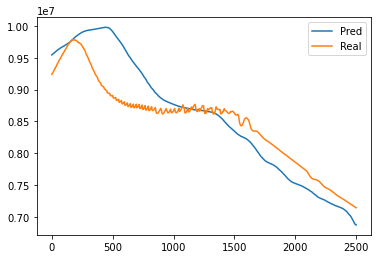

In [47]:
i=0
dim=0
plt.plot(Y_hat_up_[i,:,dim],label='Pred')
plt.plot(Y_test_[i,:,dim],label='Real')
plt.legend()


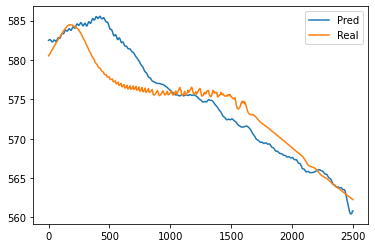

In [48]:
i=0
dim=4
plt.plot(Y_hat_up_[i,:,dim],label='Pred')
plt.plot(Y_test_[i,:,dim],label='Real')
plt.legend()

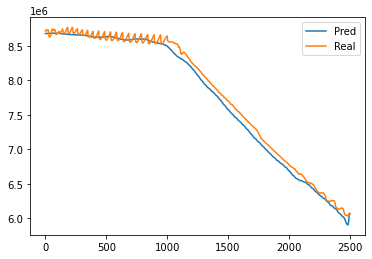

In [52]:
i=400
dim=0
plt.plot(Y_hat_up_[i,:,dim],label='Pred')
plt.plot(Y_test_[i,:,dim],label='Real')
plt.legend()

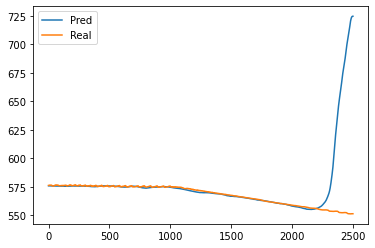

In [53]:
i=400
dim=4
plt.plot(Y_hat_up_[i,:,dim],label='Pred')
plt.plot(Y_test_[i,:,dim],label='Real')
plt.legend()

### Checkpoint  
1. 모든 데이터가 0초부터 시작하는지?? (Positional encoding 관련)
2. 열수력 코드 입력 데이터를 시퀀스로 변경 가능한지? 